In [204]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### EY analysis for the location in Golden



In [205]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pvcircuit as pvc
from pvcircuit.PlotWithControls import PlotsWithControls
import ipywidgets as widgets
from scipy import constants
from scipy import integrate
from scipy.optimize import curve_fit, fsolve
from scipy.special import erfc

from IPython import display

from pvcircuit.physics_helpers import fit_sandia_simple
from pvlib.pvsystem import singlediode

import os
import sys

from glob import glob
from datetime import datetime, timedelta
import time
from tqdm.notebook import trange
import timeit
import pickle

# set path for NREL meteorological package and import
sys.path.append("../../NREL_Meteorological")
from environmental import Spectra, Meteorological, sync
import warnings
from scipy.optimize import OptimizeWarning
from itertools import cycle
from matplotlib.lines import Line2D
import numba
import math
from scipy.interpolate import interp1d


Helpers


In [206]:
warnings.simplefilter("ignore", OptimizeWarning)


In [207]:
def wavelength_to_photonenergy(wavelength):
    return constants.h * constants.c / (wavelength * 1e-9) / constants.e


def photonenergy_to_wavelength(photonenergy):
    return constants.h * constants.c / (photonenergy * 1e-9) / constants.e


def _normalize(eqe: pd.DataFrame) -> pd.DataFrame:
    eqe_min = np.nanmin(eqe)
    eqe_max = np.nanmax(eqe)
    return (eqe - eqe_min) / (eqe_max - eqe_min)


def _eq_solve_Eg(Eg, *data):
    x, y = data
    return np.trapz(x * y, x) / np.trapz(y, x) - Eg


def _gaussian(x, a, x0, sigma):
    return 1 * np.exp(-((x - x0) ** 2) / (2 * sigma**2))


def calc_Eg_Rau(eqe, fit_gaussian=True):
    # using [1] U. Rau, B. Blank, T. C. M. Müller, and T. Kirchartz,
    # “Efficiency Potential of Photovoltaic Materials and Devices Unveiled by Detailed-Balance Analysis,”
    # Phys. Rev. Applied, vol. 7, no. 4, p. 044016, Apr. 2017, doi: 10.1103/PhysRevApplied.7.044016.
    # extended by gaussian fit

    # Define the Gaussian function
    wavelength = eqe.index.values
    y = eqe.values
    x = wavelength_to_photonenergy(wavelength)

    # convert wavelength to photon energy
    y_grad = np.abs(np.gradient(y))
    # y_grad = np.abs(np.diff(y.values, prepend=np.nan))
    # y_grad = y.diff().abs().values

    # filter tail to avoid eqe dips at end/beginning of measurement
    y_grad = y_grad[(x < (x.max() + x.min())/2)]
    y = y[(x < (x.max() + x.min())/2)]
    x = x[(x < (x.max() + x.min())/2)]
    # normalize data
    y_grad = _normalize(y_grad)
    # get the index of the maximum
    y_diff_max_idx = np.nanargmax(y_grad)
    # get the max coordinates
    x_diff_max = x[y_diff_max_idx]
    y_diff_max = y_grad[y_diff_max_idx]

    # define lower threshold
    p_ab = np.exp(-2) * y_diff_max
    thres = 0.5
    # p_ab = thres * y_diff_max
    # find the index of the low-energy side where P(a) is max(P(Eg)/2)
    a_cond = np.where((y_grad < p_ab) & (x < x_diff_max))[0]
    if len(a_cond > 0):
        a_idx = np.nanmin(a_cond)
    else:
        a_idx = len(x) - 1
    a = x[a_idx]
    p_a = y_grad[a_idx]
    # find the index of the high-energy side where P(b) is max(P(Eg)/2)
    b_idx = np.nanmax(np.where((y_grad < p_ab) & (x > x_diff_max))[0])
    b = x[b_idx]
    p_b = y_grad[b_idx]

    x_target = x[a_idx : b_idx - 1 : -1]
    y_target = y_grad[a_idx : b_idx - 1 : -1]

    if fit_gaussian:

        # initial guesses from weighted arithmetic mean and weighted sample sigma
        mean = sum(x_target * y_target) / sum(y_target)
        sigma = np.sqrt(sum(y_target * (x_target - mean) ** 2) / sum(y_target))

        fit_res = curve_fit(
            _gaussian,
            x_target,
            y_target,
            p0=[max(y_target), mean, sigma],
        )
        x_fit = np.linspace(x[b_idx], x[a_idx], 100)
        y_fit = _gaussian(x_fit, *fit_res[0])

        # fig,ax = plt.subplots(1)
        # ax.plot(x, y_grad,'.')
        # ax.plot(x_fit, y_fit)
        # ax.plot(x_target, y_target, ".r")
        # ax.plot(x_diff_max, y_diff_max, "r*")
        # ax.plot(a, p_a, "g*")
        # ax.plot(b, p_b, "b*")
        # plt.plot(x_fit - fit_res[0][1], y_fit)
        # plt.plot(x_fit, y_fit)
        # ax.set_xlim(1.1, 1.8)
        # ax.set_ylabel(r"$\frac{{\mathrm{d}}EQE}{{\mathrm{d}}E_{\nu}}$")
        # ax.set_xlabel(r"Photon energy $E_{\nu}$ [eV]")

        x_fit = x_fit[y_fit >= thres * y_fit.max()]
        y_fit = y_fit[y_fit >= thres * y_fit.max()]
        sigma = fit_res[0][2]

    else:
        fit_res = [None]
        x_fit = x_target
        y_fit = y_target
        sigma = None

    res = fsolve(_eq_solve_Eg, 1.0, args=(x_fit, y_fit))
    bandgap = res[0]
    return bandgap, sigma


def si_eg_shift(temperature, bandgap_25):
    p = [-6.47214956e-04, 1.01632828e00]
    return (p[0] * temperature + p[1]) * bandgap_25


def si_sigma_shift(temperature, sigma_25):
    p = [0.00959188, 0.76558903]
    return (p[0] * temperature + p[1])*sigma_25


def psc_eg_shift(temperature, bandgap_25):
    t_split = 32
    p = [2.59551019e-04, 9.91138163e-01]
    res = np.zeros_like(temperature)

    t_filter = temperature > t_split
    res[t_filter] = p[0] * temperature[t_filter] + p[1]
    res[~t_filter] = p[0] * t_split + p[1]
    res = pd.Series(res, index = temperature.index)
    return res * bandgap_25


def psc_sigma_shift(temperature, sigma_25):
    p = [0.00358866, 0.90074156]
    return (p[0] * temperature + p[1])*sigma_25

def intergrate_eqe(eqe):
    path_to_am15_spectra = os.path.join(os.path.dirname(os.getcwd()), "data","ASTMG173.csv")  # Data files here
    # spectra = pd.read_csv(path_to_am15_spectra, header=[*range(0,3)])
    spectra_full = pd.read_csv(path_to_am15_spectra, header=[2])
    spectra_full.set_index(spectra_full.columns[0], inplace=True)

    spectra = spectra_full.reindex(eqe.index)
    if spectra.isnull().any(axis=1).any():
        spectra = spectra.reindex(index=eqe.index).interpolate(method="index")

    # jsc = (
    #     eqe.apply(lambda x: np.trapz(y=x * spectra["global"] / qe._wavelength_to_photonenergy(eqe.index), x=eqe.index)) / 10
    # )
    jsc = np.trapz(y=eqe.values * spectra["global"] / wavelength_to_photonenergy(eqe.index), x=eqe.index) / 10
    
    
    return jsc
    si_fit = np.polyfit(temperature_silicon, jsc[1:], 1)

    temps = np.linspace(min(temperature_silicon), max(temperature_silicon), 50)
    jsc_fit = np.polyval(si_fit, temps)

    fig, ax = plt.subplots(1)
    ax.plot(temperature_silicon, jsc[1:], "*", temps, jsc_fit)

# @numba.jit()
def shift_eqe(eqe_ref, bandgap_25, sigma_25, bandgaps, sigmas, spectra):

    eqe = eqe_ref.values
    lam = eqe_ref.index.values
    Ey = constants.h * constants.c / (lam * 1e-9) / constants.e  # [eV]
    
    # abs = 1 / 2 * erfc((bandgap_25 - Ey) / (sigma_25 * np.sqrt(2)))

    lam_eqe_saturation_idx = np.argmax(eqe * lam)
    eqe_saturation = eqe[lam_eqe_saturation_idx]
    # lam_eqe_saturation = lam[lam_eqe_saturation_idx]

    # jscs = []
    # # fig,ax = plt.subplots()
    # for i, col in enumerate(bandgaps):
    #     # print(qe_data.temperature)
    #     spec = spectra.iloc[i][lam]
    #     bandgap = bandgaps[i]
    #     sigma = sigmas[i]
    #     abs = 1 / 2 * erfc((bandgap - Ey) / (sigma * np.sqrt(2))) * eqe_saturation
    #     eqe_filter = lam > photonenergy_to_wavelength(bandgap + 2*sigma)
    #     eqe_new = np.concatenate([eqe[~eqe_filter],abs[eqe_filter]])
    #     # ax.plot(eqe_new)
    #     jscs.append(np.trapz(y = eqe_new * spec / wavelength_to_photonenergy(spec.index), x = spec.index) / 10)
    
    spec_interp_func = interp1d(spectra.columns.astype(np.float64), spectra,axis=1)
    spectra_interp = pd.DataFrame(spec_interp_func(spectra.columns.astype(np.float64)), index = spectra.index, columns = spectra.columns.astype(np.float64))
        
    bandgaps_arr = np.tile(bandgaps, [len(Ey), 1])
    sigmas_arr = np.tile(sigmas, [len(Ey), 1])
    erfc_arr = (bandgaps_arr - Ey.reshape(-1,1)) / (sigmas_arr * np.sqrt(2))
    vec_erfc = np.vectorize(erfc)
    abs_arr = vec_erfc(erfc_arr) * 0.5 * eqe_saturation
    eqe_filter = np.tile(lam,[len(bandgaps),1]).T > photonenergy_to_wavelength(bandgaps_arr + 2*sigmas_arr)
    eqe_new_arr = np.tile(eqe,[len(bandgaps),1]).T    
    eqe_new_arr = eqe_new_arr * ~eqe_filter + abs_arr * eqe_filter
    # jscs = np.trapz(y = eqe_new_arr * spectra[lam].T  / wavelength_to_photonenergy(lam).reshape(-1,1), x = lam.reshape(-1,1),axis=0) / 10
    
    jscs = (
        np.trapz(
            y=eqe_new_arr * spectra_interp[lam].values.T / wavelength_to_photonenergy(lam).reshape(-1, 1), x=lam.reshape(-1, 1), axis=0
        )
        / 10
    )

    
    # jscs = (
    #     np.trapz(
    #         y=eqe_new_arr * spectra_interp[lam].values.T / wavelength_to_photonenergy(lam).reshape(-1, 1), x=lam.reshape(-1, 1), axis=0
    #     )
    #     / 10
    # )
    
    # print(f"check jscs = {all(jscs_arr == np.array(jscs))}")
    
    return jscs
    


Some notebook settings

In [208]:
t_elaps = None
t_elapsMP = None

squeeze_day_to_one_day = True # squeezes the meteo data into one day to allow plot comparison in one day
results = None

Load the meteorological data

In [209]:
def get_meteo(date_start, date_end, resampler):
    
    # date_start = datetime(2022, 6, 15, 0, 0, 0)  # sunny day
    # date_end = date_start + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)
    meteo_data = Meteorological.get_midc_environmental(date_start, date_end)
    # spectra_class = Spectra.get_srrl_wiser_global_track(date_start, date_end)
    spectra_class = Spectra.get_srrl_solarsim_direct_normal(date_start, date_end)
    
    
    

    # resample
    spectra_resampled = spectra_class.spectra.resample(resampler).median()
    meteo_resampled = meteo_data.data.resample(resampler).median()

    spectra_sync, meteo_sync = sync(spectra_resampled, meteo_resampled)

    # remove nan
    nan_filter = spectra_sync.isna().any(axis=1) | meteo_sync.isna().any(axis=1)
    spectra_sync = spectra_sync[~nan_filter]
    meteo_sync = meteo_sync[~nan_filter]
    
    #remove negative spectral data
    spec_filter = (spectra_sync<-1).any(axis=1)
    spectra_sync = spectra_sync[~spec_filter]
    meteo_sync = meteo_sync[~spec_filter]

    # if squeeze_days_to_one_day:
    #     meteo_data.data.index = meteo_data.data.index.map(lambda dt: dt.replace(day=1))
    
    # import TMY data of meteo_location
    meteo_location = pvc.Meteo(
        wavelength=spectra_sync.columns.astype(np.float32),
        spectra=spectra_sync,
        ambient_temperature=meteo_sync["Deck Dry Bulb Temp [deg C]"],
        wind=meteo_sync["Avg Wind Speed @ 19ft [m/s]"],
        daytime=spectra_sync.index,
    )
    return meteo_location


Hard code scenarios for cell data

In [210]:
def get_jv_params(fp_psk_jv, fp_si_jv, plot_fits:bool=False):
    path = os.path.join(os.path.dirname(os.getcwd()), "data")  # Data files here

    psk_data = pd.read_csv(os.path.join(path, fp_psk_jv))
    A = 1  # [cm^2]
    TC = 25  # [degC]

    # Measured terminal voltage.
    voltage = psk_data["v"].to_numpy(np.double)  # [V]
    # Measured terminal current.
    current = psk_data["i"].to_numpy(np.double) / 1000 * A  # [A/cm^2]

    sort_id = np.argsort(voltage)

    voltage = voltage[sort_id]
    current = current[sort_id]

    voc_guess_idx = np.where(current >= 0)[0][-1]
    voltage = voltage[: voc_guess_idx + 2]
    current = current[: voc_guess_idx + 2]

    # fit iv
    # (psc_isc, psc_io, psc_rs, psc_rsh, psc_nNsVth) = psc_params
    psc_params = fit_sandia_simple(  # [A/cm^2]  # [A/cm^2]  # [Ohm cm^2]  # [Ohm cm^2]
        voltage, current
    )
    ilim = 0.6
    while psc_params[2] < 0:
        ilim -=0.01        
        # fit iv
        psc_params = fit_sandia_simple(  # [A/cm^2]  # [A/cm^2]  # [Ohm cm^2]  # [Ohm cm^2]
            voltage, current, ilim=ilim
        )
        
    if plot_fits:
        fit = singlediode(*psc_params, ivcurve_pnts=30)
        fig,ax = plt.subplots()
        ax.plot(voltage,current,"k*",label="psc-data")
        ax.plot(fit["v"],fit["i"],"k--",label="psc-fit")
        
        
    si_data = pd.read_csv(os.path.join(path, fp_si_jv))
    # Measured terminal voltage.
    voltage = si_data["v"].to_numpy(np.double)  # [V]
    # Measured terminal current.
    current = si_data["i"].to_numpy(np.double) / 1000 * A  # [A]

    sort_id = np.argsort(voltage)

    voltage = voltage[sort_id]
    current = current[sort_id]

    voc_guess_idx = np.where(current >= 0)[0][-1]
    voc_guess_idx
    voltage = voltage[: voc_guess_idx + 2]
    current = current[: voc_guess_idx + 2]

    # fit iv
    si_params = fit_sandia_simple(  # [A]  # [A]  # [Ohm]  # [Ohm]
        voltage, current
    )
    ilim = 0.6
    while si_params[2] < 0:
        ilim -=0.01        
        # fit iv
        si_params = fit_sandia_simple(  # [A]  # [A]  # [Ohm]  # [Ohm]
            voltage, current, ilim=ilim
        )
    
    if plot_fits:
        fit = singlediode(*si_params, ivcurve_pnts=30)
        ax.plot(voltage,current,"rx",label="Si-data")
        ax.plot(fit["v"],fit["i"], "r--",label="Si-fit")
        
    return psc_params, si_params

In [211]:
def get_tandem_eqe(fp_psk_eqe, fp_psk_trans, fp_si_eqe, psc_params, si_params):
    
    # get the Silicon paramters
    (psc_isc, psc_io, psc_rs, psc_rsh, psc_nNsVth) = psc_params
    (si_isc,si_io, si_rs, si_rsh, si_nNsVth) = si_params
    
    A = 1  # [cm^2]
    TC = 25  # [degC]
    
    reader_settings = {"index_col": 0, "usecols": [0, 1]}
    df_psk_eqe = pd.read_excel(fp_psk_eqe, **reader_settings).dropna().squeeze("columns")
    df_psk_trans = pd.read_csv(fp_psk_trans, **reader_settings).dropna().squeeze("columns")
    df_si_eqe = pd.read_excel(fp_si_eqe, **reader_settings).dropna().squeeze("columns")

    df_psk_trans = None
    if df_psk_trans is None:
        df_psk_trans = 1 - _normalize(df_psk_eqe)
        
    # in case values are percentages
    if any(df_psk_eqe.values > 1):
        df_psk_eqe = df_psk_eqe.div(100)
    if any(df_psk_trans.values > 1):
        df_psk_trans = df_psk_trans.div(100)
    if any(df_si_eqe.values > 1):
        df_si_eqe = df_si_eqe.div(100)

    # # round in case wavelength has many floating points
    df_psk_eqe.index = np.round(df_psk_eqe.index.astype(np.double), 1)
    df_psk_trans.index = np.round(df_psk_trans.index.astype(np.double), 1)
    df_si_eqe.index = np.round(df_si_eqe.index.astype(np.double), 1)

    # integrate the EQE and compare the Jsc with the Jsc form the IV data. Assumption here is that the Jsc from IV measurement is the true value and EQE needs to be scaled
    eqe_scaler = psc_isc / A * 1e3 / intergrate_eqe(df_psk_eqe)
    df_psk_eqe = df_psk_eqe * eqe_scaler

    eqe_scaler = si_isc / A * 1e3 / intergrate_eqe(df_si_eqe)
    df_si_eqe = df_si_eqe * eqe_scaler

    # interpolate with eqe's superseding transmission wavelengths
    comb_lam = df_psk_eqe.index.union(df_si_eqe.index)
    df_psk_eqe_interp = df_psk_eqe.reindex(index=comb_lam, fill_value=0.0).interpolate(method="index")
    df_psk_trans_interp = df_psk_trans.reindex(index=comb_lam).interpolate(method="index")
    df_si_eqe_interp = df_si_eqe.reindex(index=comb_lam, fill_value=0.0).interpolate(method="index")
    
    
    eqe_max_idx = df_psk_eqe_interp.idxmax()
    filter_idx = (df_psk_eqe_interp.values < 0.01) & (df_psk_trans_interp.index.values > eqe_max_idx)
    df_psk_trans_interp[filter_idx] = 1

    df_si_eqe_filtered = df_psk_trans_interp * df_si_eqe_interp

    # get the bandgap to cut-off eqe of bottom cell where eqe of the top cell is weak
    eg_psc, sigma_psc = calc_Eg_Rau(df_psk_eqe_interp)
    lam_cut_psc = photonenergy_to_wavelength(eg_psc + 2 * sigma_psc)

    df_si_eqe_filtered[df_psk_eqe_interp.index <= lam_cut_psc] = 0

    # commbine Psk and filter EQE
    df_tandem_eqe = pd.concat([df_psk_eqe_interp, df_si_eqe_filtered], axis=1)
    df_tandem_eqe.columns = ["Psk", "Si"]
    
    
    return df_tandem_eqe, df_si_eqe_interp


In [212]:
def match_eqe_spectra(df_tandem_eqe, spectra_sync):
    spectra_sync = spectra_sync.reindex(df_tandem_eqe.index,axis=1)
    spec_filter = ~spectra_sync.isna().all()
    spectra_sync = spectra_sync.iloc[:,spec_filter.values]
    df_tandem_eqe = df_tandem_eqe[spec_filter]
    return df_tandem_eqe, spectra_sync

In [213]:
def get_tandem_device(psc_params, si_params, df_si_eqe_filtered, eg_psc, eg_si):

    (psc_isc, psc_io, psc_rs, psc_rsh, psc_nNsVth) = psc_params
    (si_isc,si_io, si_rs, si_rsh, si_nNsVth) = si_params


    jo_scale = 1000
    A = 1  # [cm^2]
    TC = 25  # [degC]

    psc_jsc = psc_isc / A  # [A/cm^2]
    psc_jo = psc_io / A
    psc_n = psc_nNsVth / pvc.junction.Vth(TC)
    psc_jdb = pvc.junction.Jdb(TC=TC, Eg=eg_psc)
    psc_joratio = jo_scale * psc_jo / (psc_jdb * jo_scale) ** (1.0 / psc_n)
    psc_joratio = 300

    psc_rser = psc_rs * A
    psc_gsh = 1 / (psc_rsh * A)

    si_jsc = si_isc / A  # [A/cm^2]
    si_jo = si_io / A
    si_n = si_nNsVth / pvc.junction.Vth(TC)
    si_jdb = pvc.junction.Jdb(TC=TC, Eg=eg_si)
    si_joratio = jo_scale * si_jo / (si_jdb * jo_scale) ** (1.0 / si_n)
    
    si_jsc = intergrate_eqe(df_si_eqe_filtered) / 1e3
    

    si_rser = si_rs * A
    si_gsh = 1 / (si_rsh * A)

    dev3T = pvc.Tandem3T()
    dev3T.set(name="PskSidev3T", Rz=0)
    dev3T.top.set(Eg=eg_psc, J0ratio=[psc_joratio], Jext=psc_jsc, Gsh=psc_gsh, Rser=psc_rser, n=[psc_n], beta = 0, JLC = 0)
    dev3T.bot.set(Eg=eg_si, J0ratio=[si_joratio], Jext=si_jsc, Gsh=si_gsh, Rser=si_rser, n=[si_n], beta = 0, JLC = 0)
    return dev3T

In [214]:
# import EQE of Psk and Tandem
# Transmittance data
# Pvsk_1.53eV_Qi_3-22_tr.csv
# Pvsk_1.60eV_Qi_3-22_tr.csv
# Pvsk_1.63eV_Qi_3-22_tr.csv
# Pvsk_1.70eV_Qi_3-22_tr.csv

# PSC EQE data
# Pvsk_1.25eV_QE.xlsx
# Pvsk_1.63MA-free_QE.xlsx
# Pvsk_1.68eV_QE.xlsx
# Pvsk_1.70MA-free_QE.xlsx
# Pvsk_1.75MA-free_QE.xlsx
# Pvsk_1.80MA-free_QE.xlsx
path = os.path.join(os.path.dirname(os.getcwd()), "data")  # Data files here

datalist = glob(path + "**" + os.path.sep +"*")
# print(*(f"{i:>2} --> {os.path.basename(x)}" for i, x in enumerate(datalist)), sep="\n")

fp_psk_eqe = {
    1.25 : [file for file in datalist if "1.25" in file and "_QE" in file][0],
    1.58 : [file for file in datalist if "1.58" in file and "_QE" in file][0],
    1.63 : [file for file in datalist if "1.63" in file and "_QE" in file][0],
    1.68 : [file for file in datalist if "1.68" in file and "_QE" in file][0],
    1.70 : [file for file in datalist if "1.70" in file and "_QE" in file][0],
    1.75 : [file for file in datalist if "1.75" in file and "_QE" in file][0],
    1.80 : [file for file in datalist if "1.80" in file and "_QE" in file][0]
}

fp_psk_trans = {
    1.25 : [file for file in datalist if "1.53" in file and "_tr" in file][0],
    1.58 : [file for file in datalist if "1.63" in file and "_tr" in file][0],
    1.63 : [file for file in datalist if "1.63" in file and "_tr" in file][0],
    1.68 : [file for file in datalist if "1.63" in file and "_tr" in file][0],
    1.70 : [file for file in datalist if "1.70" in file and "_tr" in file][0],
    1.75 : [file for file in datalist if "1.70" in file and "_tr" in file][0],
    1.80 : [file for file in datalist if "1.70" in file and "_tr" in file][0]
}

fp_psk_jv = {
    1.25 : [file for file in datalist if "1.25" in file and "_JV" in file][0],
    1.58 : [file for file in datalist if "1.58" in file and "_JV" in file][0],
    1.63 : [file for file in datalist if "1.63" in file and "_JV" in file][0],
    1.68 : [file for file in datalist if "1.68" in file and "_JV" in file][0],
    1.70 : [file for file in datalist if "1.70" in file and "_JV" in file][0],
    1.75 : [file for file in datalist if "1.75" in file and "_JV" in file][0],
    1.80 : [file for file in datalist if "1.80" in file and "_JV" in file][0]
}


# file_psk_trans = "Pvsk0111D_1.7sb_tr.csv"
fp_si_eqe = [file for file in datalist if "Si_101_E1_005_14_2B_postITO_QE.xlsx" in file][0] 
fp_si_jv = [file for file in datalist if "Si_101_E1_005_14_2B_postITO_JV.csv" in file][0]




In [215]:
date_start = datetime(2021, 11, 1, 0, 0, 0)

# date_start = date_end - pd.Timedelta(days=1) + pd.Timedelta(seconds=1)
# date_end = date_start.replace(day=date_start.day + 7) - pd.Timedelta(seconds=1)
# date_end = date_start.replace(month=date_start.month+1) - pd.Timedelta(seconds=1)
# date_end = date_start.replace(year=date_start.year + 1) - pd.Timedelta(seconds=1)

date_end = datetime(2022, 11, 1, 0, 0, 0) - pd.Timedelta(seconds=1)

# meteo_location = get_meteo(date_start, date_end, "1T")

# with open("outfile.p", "wb") as fout:
#     pickle.dump(meteo_location,fout)

# for the global 2-axis track
with open("meteo_year.p", "rb") as fin:
    meteo_location = pickle.load(fin)


# for the direct 2-axis track
# with open("direct_meteo_year.p", "rb") as fin:
#     meteo_location = pickle.load(fin)

print("calculating currents")

currents = pd.DataFrame(
    np.zeros([meteo_location.spectra.shape[0], len(fp_psk_eqe.keys()) * 2]),
    index=meteo_location.spectra.index,
    columns=[
        f"{jsc}_{eg}"
        for jsc, eg in zip(
            ["Jsctop", "Jscbot"] * len(list(fp_psk_eqe.keys())), [eg for eg in list(fp_psk_eqe.keys()) for _ in range(2)]
        )
    ],
)

for idx, eg in enumerate(fp_psk_eqe.keys()):

    psc_params, si_params = get_jv_params(fp_psk_jv[eg], fp_si_jv)
    df_tandem_eqe, df_si_eqe_interp = get_tandem_eqe(fp_psk_eqe[eg], fp_psk_trans[eg], fp_si_eqe, psc_params, si_params)
    # df_tandem_eqe, meteo_location.spectra = match_eqe_spectra(df_tandem_eqe, meteo_location.spectra)
    df_psk_eqe_interp = df_tandem_eqe.iloc[:, 0]
    df_si_eqe_filtered = df_tandem_eqe.iloc[:, 1]

    # dev3T.top.set(Rser=Rz)

    # spectra = wiser_global_horizontal.spectra.loc[date_plot]
    spectra = meteo_location.spectra.T
    spectra.index = meteo_location.wavelength

    spectra_interp = spectra.reindex(index=df_psk_eqe_interp.index).interpolate(method="index")

    # spectra = wiser_global_horizontal.spectra.loc[date_start:date_end].T
    Jsc_top = np.trapz(
        constants.e
        / constants.h
        / constants.c
        * spectra_interp.index.values.reshape(-1, 1)
        * spectra_interp.values
        * df_psk_eqe_interp.values.reshape(-1, 1)
        * 1e-10,
        x=spectra_interp.index,
        axis=0,
    )
    Jsc_bottom = np.trapz(
        constants.e / constants.h / constants.c * spectra_interp.index.values.reshape(-1, 1) * spectra_interp.values
        # * df_si_eqe_interp.values
        * df_si_eqe_filtered.values.reshape(-1, 1) * 1e-10,
        x=spectra_interp.index,
        axis=0,
    )

    currents.iloc[:, 2 * idx] = Jsc_top
    currents.iloc[:, 2 * idx + 1] = Jsc_bottom
    
# remove negative currents
neg_current_mask = (currents > 0).all(axis=1)
currents = currents[neg_current_mask]

# markers = cycle(Line2D.markers)
# fig, ax = plt.subplots(1)
# lines = ax.plot(currents)
# for line in lines:
#     line.set_marker(next(markers))
# leg = ax.legend(currents.columns)


calculating currents


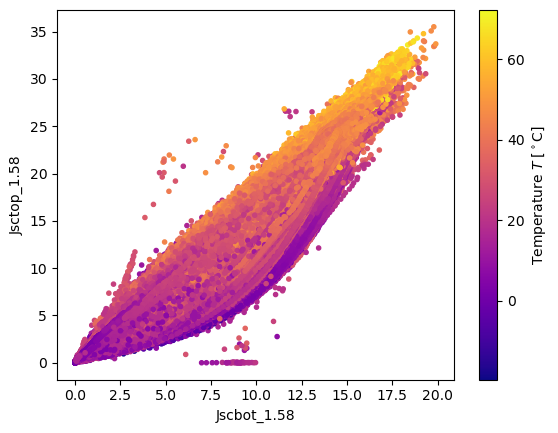

In [216]:
n = 1
resampler = "1T"
fig, ax = plt.subplots()
# ax.plot(currents.resample(resampler).mean().iloc[:, (2 * n) + 1], currents.resample(resampler).mean().iloc[:, (2 * n)], ".")
cmap = plt.colormaps.get("plasma")
sp = ax.scatter(currents.resample(resampler).mean().iloc[:, (2 * n) + 1], currents.resample(resampler).mean().iloc[:, (2 * n)], None, meteo_location.TempCell.resample(resampler).mean(), marker=".", cmap=cmap)
ax.set_xlabel(currents.resample(resampler).mean().columns[(2 * n) + 1])
ax.set_ylabel(currents.resample(resampler).mean().columns[(2 * n)])

plt.colorbar(sp, ax=ax, orientation="vertical", label="Temperature $T$ [$^\\circ$C]")

In [220]:
egs[1:6]

[1.58, 1.63, 1.68, 1.7, 1.75]

In [221]:
egs = list(fp_psk_eqe.keys())

cols = [
    "Eg",
    "Tcell",
    "topcurrent",
    "bottomcurrent",
    "Pin",
    "P2Tout",
    "P4Tout",
]

eta_missmatch = pd.DataFrame(np.zeros([len(meteo_location.spectra) * len(egs[1:6]), len(cols)]), columns=cols)

tic = time.time()

for id_eg in trange(len(egs[1:6])):
    eg = egs[1:6][id_eg]
    psc_params, si_params = get_jv_params(fp_psk_jv[eg], fp_si_jv)
    df_tandem_eqe, df_si_eqe_interp = get_tandem_eqe(fp_psk_eqe[eg], fp_psk_trans[eg], fp_si_eqe, psc_params, si_params)
    # df_tandem_eqe, meteo_location.spectra = match_eqe_spectra(df_tandem_eqe, meteo_location.spectra)
    df_psk_eqe_interp = df_tandem_eqe.iloc[:, 0]
    df_si_eqe_filtered = df_tandem_eqe.iloc[:, 1]

    eg_si, sigma_si = calc_Eg_Rau(df_si_eqe_interp)
    eg_psc, sigma_psc = calc_Eg_Rau(df_psk_eqe_interp)

    eg_si, sigma_si = calc_Eg_Rau(df_si_eqe_interp)
    egs_si = si_eg_shift(meteo_location.TempCell, eg_si)
    sigmas_si = si_sigma_shift(meteo_location.TempCell, sigma_si)

    eg_psc, sigma_psc = calc_Eg_Rau(df_psk_eqe_interp)
    egs_psc = psc_eg_shift(meteo_location.TempCell, eg_psc)
    sigmas_psc = psc_sigma_shift(meteo_location.TempCell, sigma_psc)

    si_jscs = shift_eqe(df_si_eqe_filtered, eg_si, sigma_si, egs_si, sigmas_si, meteo_location.spectra)
    psc_jscs = shift_eqe(df_psk_eqe_interp, eg_psc, sigma_psc, egs_psc, sigmas_psc, meteo_location.spectra)

    # make numpy
    si_jscs = pd.DataFrame(si_jscs, index=meteo_location.spectra.index, columns=["si_jscs"])
    psc_jscs = pd.DataFrame(psc_jscs, index=meteo_location.spectra.index, columns=["psc_jscs"])

    eqe = df_tandem_eqe.to_numpy(dtype=np.float64, copy=True)
    lam = df_tandem_eqe.index.to_numpy(dtype=np.float64, copy=True)

    EQE2J = pvc.EQE(eqe, lam, "Psk-Si")  # EQE class
    EQE2J.sjuncs = ["Psk", "Si"]  # rename junctions

    dev3T = get_tandem_device(psc_params, si_params, df_si_eqe_filtered, eg_psc, eg_si)

    for row in trange(len(meteo_location.spectra)):

        powerIn = np.trapz(
            x=meteo_location.spectra.iloc[row, :].index.astype(np.float32), y=meteo_location.spectra.iloc[row, :].values
        )

        dev3T.top.set(Jext=psc_jscs.iloc[row].values[0] / 1e3, TC=meteo_location.TempCell[row], Eg=egs_psc[row])
        dev3T.bot.set(Jext=si_jscs.iloc[row].values[0] / 1e3, TC=meteo_location.TempCell[row], Eg=egs_si[row])

        _, iv3t = dev3T.CM()
        power2T = iv3t.Ptot[0]
        iv3t = dev3T.MPP()
        power4T = iv3t.Ptot[0]

        eta_missmatch.loc[len(meteo_location.spectra) * id_eg + row, "Eg"] = eg
        eta_missmatch.loc[len(meteo_location.spectra) * id_eg + row, "Tcell"] = meteo_location.TempCell[row]
        eta_missmatch.loc[len(meteo_location.spectra) * id_eg + row, "topcurrent"] = psc_jscs.iloc[row].values[0]
        eta_missmatch.loc[len(meteo_location.spectra) * id_eg + row, "bottomcurrent"] = si_jscs.iloc[row].values[0]
        eta_missmatch.loc[len(meteo_location.spectra) * id_eg + row, "Pin"] = powerIn
        eta_missmatch.loc[len(meteo_location.spectra) * id_eg + row, "P2Tout"] = power2T
        eta_missmatch.loc[len(meteo_location.spectra) * id_eg + row, "P4Tout"] = power4T
    # eta_missmatch = eta_missmatch[~(eta_missmatch == 0).all(axis=1)]

toc = time.time()
elapsed_time = toc - tic


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/265667 [00:00<?, ?it/s]

In [ ]:
# cpu_count = mp.cpu_count()
#         print(f"running multiprocess with {cpu_count} pools")
#         with tqdm(total=len(self.inPower), leave=True, desc = f"Multi processing {oper}") as pbar:

#             dev_list = [copy.deepcopy(model) for _ in range(len(self.Jscs))]
#             with mp.Pool(cpu_count) as pool:
#                 def callback(*args):
#                     # callback
#                     pbar.update()
#                     return

#                 results = list(
#                     pool.apply_async(_calc_yield_async, args=(i, bot, top, type3T, self.Jscs, self.Egs, self.TempCell, dev_list, oper), callback=callback)
#                     for i, _ in enumerate(self.inPower)
#                 )
#                 results = [r.get() for r in results]
                
#         self.outPowerMP = results

In [65]:
elapsed_time / 60 / 60

45.98013813111517

In [62]:
eta_missmatch = pd.DataFrame(np.zeros([len(meteo_location.spectra) * len(egs[1:4]), len(cols)]), columns=cols)

tic = time.time()

for id_eg in trange(len(egs[1:4])):
    for row in trange(len(meteo_location.spectra)):
        eta_missmatch.loc[len(meteo_location.spectra) * id_eg + row, "Eg"] = egs[1:4][id_eg]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/205509 [00:00<?, ?it/s]

  0%|          | 0/205509 [00:00<?, ?it/s]

  0%|          | 0/205509 [00:00<?, ?it/s]

In [67]:
eta_missmatch["Eg"].unique()

array([1.58, 1.63, 1.68])

In [68]:
# with open("fullyear_158163168.p", "wb") as fout:
#     pickle.dump(eta_missmatch,fout)


In [172]:
with open("fullyear_168.p", "rb") as fin:
    eta_missmatch = pickle.load(fin)


In [184]:
psc_params, si_params = get_jv_params(fp_psk_jv[1.63], fp_si_jv)
psc_params

(0.020414868270923744,
 1.8610568740481384e-15,
 0.2932304527300246,
 4271.423820568867,
 0.03962279581556136)

In [173]:
eta_missmatch["P2Tout"] / eta_missmatch["Pin"] * 1e4


2021-11-01 10:47:00    0.007215
2021-11-02 10:36:00    0.008142
2021-11-02 10:37:00    0.010957
2021-11-02 10:38:00    0.013919
2021-11-02 10:39:00    0.025901
                         ...   
2022-10-31 16:29:00    0.212676
2022-10-31 16:30:00    0.210243
2022-10-31 16:31:00    0.206895
2022-10-31 16:32:00    0.191790
2022-10-31 16:33:00    0.160744
Length: 205509, dtype: float64

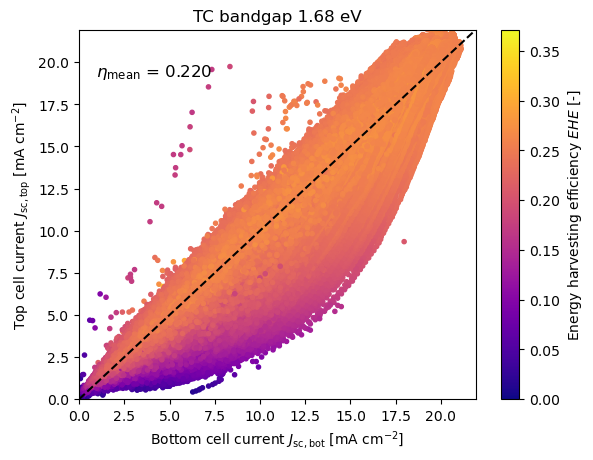

In [174]:
max_current = max(eta_missmatch["topcurrent"].max(), eta_missmatch["bottomcurrent"].max())

eta = eta_missmatch["P2Tout"] / eta_missmatch["Pin"] * 1e4
max_eta = eta.max()


fig, ax = plt.subplots()
cmap = plt.colormaps.get("plasma")
# sp = plt.scatter(eta_group["bot_mid"], eta_group["bot_mid"] + eta_group["diff_mid"],eta_group["Pout"]/eta_group["Pin"]*1e4 * 1e2, eta_group["bin_count"],marker="*", cmap=cmap)
sp = ax.scatter(
    eta_missmatch["bottomcurrent"],
    eta_missmatch["topcurrent"],
    None,
    eta,
    marker=".",
    cmap=cmap,
    # norm = "log",
    vmin=0,
    vmax = max_eta
)
plt.colorbar(sp, ax=ax, orientation="vertical", label="Energy harvesting efficiency $EHE$ [-]")

# current matches lines
ax.plot([0, max_current], [0, max_current], "k--")

# limits
ax.set_xlim(0, max_current)
ax.set_ylim(0, max_current)
# captions
ax.set_title(f"TC bandgap {eta_missmatch['Eg'][0]} eV")
ax.set_xlabel("Bottom cell current $J_\mathrm{sc,bot}$ [mA cm$^{-2}$]")
ax.set_ylabel("Top cell current $J_\mathrm{sc,top}$ [mA cm$^{-2}$]")
anno = ax.annotate(f"$\\eta_\mathrm{{mean}}$ = {eta.mean():.3f}",xy=(0.15,0.8), xycoords='figure fraction', fontsize=12)
# anno = ax.annotate(f"$\\eta_\mathrm{{median}}$ = {median_group_eta:.3f}" ,xy=(0.15,0.8), xycoords='figure fraction', fontsize=12)

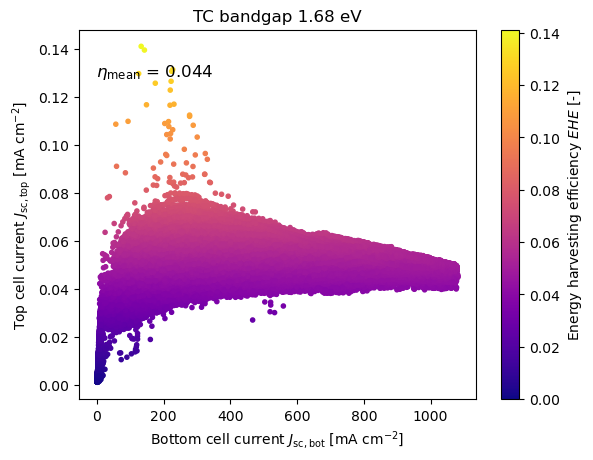

In [158]:
fig, ax = plt.subplots()
cmap = plt.colormaps.get("plasma")
# sp = plt.scatter(eta_group["bot_mid"], eta_group["bot_mid"] + eta_group["diff_mid"],eta_group["Pout"]/eta_group["Pin"]*1e4 * 1e2, eta_group["bin_count"],marker="*", cmap=cmap)
sp = ax.scatter(
    eta_missmatch["Pin"],
    eta,
    None,
    eta,
    marker=".",
    cmap=cmap,
    # norm = "log",
    vmin=0,
    vmax = max_eta
)
plt.colorbar(sp, ax=ax, orientation="vertical", label="Energy harvesting efficiency $EHE$ [-]")

# current matches lines
# ax.plot([0, max_current], [0, max_current], "k--")

# limits
# captions
ax.set_title(f"TC bandgap 1.68 eV")
ax.set_xlabel("Bottom cell current $J_\mathrm{sc,bot}$ [mA cm$^{-2}$]")
ax.set_ylabel("Top cell current $J_\mathrm{sc,top}$ [mA cm$^{-2}$]")
anno = ax.annotate(f"$\\eta_\mathrm{{mean}}$ = {eta.mean():.3f}",xy=(0.15,0.8), xycoords='figure fraction', fontsize=12)
# anno = ax.annotate(f"$\\eta_\mathrm{{median}}$ = {median_group_eta:.3f}" ,xy=(0.15,0.8), xycoords='figure fraction', fontsize=12)

In [ ]:

egs = list(fp_psk_eqe.keys())
eg = egs[2]
psc_params, si_params = get_jv_params(fp_psk_jv[eg], fp_si_jv)
df_tandem_eqe, df_si_eqe_interp = get_tandem_eqe(fp_psk_eqe[eg], fp_psk_trans[eg], fp_si_eqe, psc_params, si_params)
df_psk_eqe_interp = df_tandem_eqe.iloc[:, 0]
eg_si, sigma_si = calc_Eg_Rau(df_si_eqe_interp)
eg_psc, sigma_psc = calc_Eg_Rau(df_psk_eqe_interp)
dev3T = get_tandem_device(psc_params, si_params, df_si_eqe_filtered, eg_psc, eg_si)
# dev3T = pvc.Tandem3T()
# dev3T.top.pn = 1
# dev3T.top.J0ratio = dev3T.bot.J0ratio
# dev3T.top.Eg = dev3T.bot.Eg
# dev3T.top.n = dev3T.bot.n
# dev3T.top.Rser = 0
# dev3T.top.Gsh = 0
# dev3T.bot.Rser = 0
# dev3T.bot.Gsh = 0



dev2T = pvc.Multi2T.from_3T(dev3T)
ratios = np.linspace(0.3,1.7,20)

etas = []
etas2T = []
jsctop = []
jscbot = []
for ratio in ratios:
    dev3T.top.Jext = dev3T.bot.Jext * ratio
    dev2T.j[0].Jext = dev2T.j[1].Jext * ratio
    
    _, iv3t = dev3T.CM()
    etas.append(iv3t.Ptot[0])
    jsctop.append(dev3T.top.Jext)
    jscbot.append(dev3T.bot.Jext)
    etas2T.append(dev2T.MPP()['Pmp'])
    
fig,ax = plt.subplots(1)
ax.plot(ratios, etas)
ax.plot(ratios, etas2T)
# ax2=ax.twinx()
# ax2.plot(ratios, jsctop)
# ax2.plot(ratios, jscbot)

In [ ]:
for id_eg in trange(len(egs)):
    eg = egs[id_eg]
    psc_params, si_params = get_jv_params(fp_psk_jv[eg], fp_si_jv)
    df_tandem_eqe, df_si_eqe_interp = get_tandem_eqe(fp_psk_eqe[eg], fp_psk_trans[eg], fp_si_eqe, psc_params, si_params)
    # df_tandem_eqe, meteo_location.spectra = match_eqe_spectra(df_tandem_eqe, meteo_location.spectra)
    df_psk_eqe_interp = df_tandem_eqe.iloc[:, 0]
    df_si_eqe_filtered = df_tandem_eqe.iloc[:, 1]

    eg_si, sigma_si = calc_Eg_Rau(df_si_eqe_interp)

    eg_si, sigma_si = calc_Eg_Rau(df_si_eqe_interp)

    dev3T = get_tandem_device(psc_params, si_params, df_si_eqe_filtered, eg_psc, eg_si)
    
    fig,ax = plt.subplots(1,3,sharex=True,figsize=(15, 5))
    for eg in fp_psk_eqe.keys():
        
        psc_params, si_params = get_jv_params(fp_psk_jv[eg], fp_si_jv)
        # (psc_isc, psc_io, psc_rs, psc_rsh, psc_nNsVth) = psc_params
        ax[0].plot(eg,psc_params[0]*1e3,"x")
        ax[1].plot(eg,psc_params[1]*1e3,"x")
        ax[2].plot(eg,psc_params[2],"x")
    ax[1].set_yscale("log")

    ax[1].set_xlabel("Band gap Eg [eV]")
    ax[0].set_ylabel("Current density [mA/cm^2]")
    ax[1].set_ylabel("Sat. current [mA/cm^2]")
    ax[2].set_ylabel("Series resistance [Ohm cm^2]")
    plt.tight_layout()
    psc_params[0] * 1e3
    

In [ ]:
dev3T = get_tandem_device(psc_params, si_params, df_si_eqe_filtered, eg_psc, eg_si)
_, iv3t = dev3T.CM()
iv3t.Ptot[0]


In [ ]:
eta_missmatch_clean = eta_missmatch[~(eta_missmatch == 0).all(axis=1)]

eta_missmatch_g = eta_missmatch_clean.groupby("Eg")
group_names = list(eta_missmatch_g.groups.keys())

n_choose = 2

eta_group = eta_missmatch_g.get_group(group_names[n_choose]).copy()

max_current = max(si_jscs.max().values[0], psc_jscs.max().values[0])
max_eta = max(eta_missmatch_clean["Pout"] / eta_missmatch_clean["Pin"] * 1e4)
max_eta = 0.4
max_group_eta = max(eta_group["Pout"] / eta_group["Pin"] * 1e4)
mean_group_eta = np.mean(eta_group["Pout"] / eta_group["Pin"] * 1e4)

bin_energy = eta_group["bin_count"] * eta_group["Pin"]
scatter_size = (bin_energy - min(bin_energy)) / (max(bin_energy) - min(bin_energy)) * 500

temps = eta_group["Tcell"].apply(lambda x:x.mid)
fig, ax = plt.subplots()
cmap = plt.colormaps.get("plasma")
# sp = plt.scatter(eta_group["bot_mid"], eta_group["bot_mid"] + eta_group["diff_mid"],eta_group["Pout"]/eta_group["Pin"]*1e4 * 1e2, eta_group["bin_count"],marker="*", cmap=cmap)
sp = ax.scatter(
    temps,
    eta_group["Pout"] / eta_group["Pin"] * 1e4,
    scatter_size,
    eta_group["Pout"] / eta_group["Pin"] * 1e4,
    marker=".",
    cmap=cmap,
    # norm = "log",
    vmin=0,
    vmax = max_eta
)
plt.colorbar(sp, ax=ax, orientation="vertical", label="Conversion efficiency $\\eta$ [1]")

# current matches lines

# limits# captions
ax.set_title(f"TC bandgap {group_names[n_choose]} eV")
ax.set_xlabel("Temperature $T$ [C]")
ax.set_ylabel("Conversion efficiency $\\eta$ [1]")
anno = ax.annotate(f"$\\eta_\mathrm{{mean}}$ = {mean_group_eta:.2f}",xy=(0.15,0.8), xycoords='figure fraction')

In [ ]:
eta_missmatch[~(eta_missmatch == 0).all(axis=1)]

In [ ]:
# with open("2023-01-08_run1_tcbc-binvar.p", "wb" ) as fout:
#     pickle.dump(eta_missmatch,fout)
# # all(test == eta_missmatch)

In [ ]:
with open("2023-01-08_run1_tcbc-binvar.p", "rb" ) as fin:
    test = pickle.load(fin)
all(test == eta_missmatch)

In [ ]:
Rz = 0

eg_si = 1.12

egs = np.linspace(eg_si + 0.1,2,30)
currents_ideal = pd.DataFrame(np.zeros([meteo_location.spectra.shape[0], len(egs) * 2]), index = meteo_location.spectra.index, columns = [f"{jsc}_{eg}" for jsc,eg in zip(["Jsctop","Jscbot"] * len(egs), [eg for eg in egs for _ in range(2)])])

for idx, eg_psc in enumerate(egs):
    
    lam_thres = np.round(photonenergy_to_wavelength(eg_psc))
    
    # lam_top = np.arange(300,lam_thres,1)
    # lam_bot = np.arange(lam_thres,photonenergy_to_wavelength(eg_si))
    
    # eqe_top = np.ones(lam_top.shape)
    # eqe_bot = np.ones(lam_bot.shape)
    
    lam = np.arange(300,photonenergy_to_wavelength(eg_si),1)
    eqe_top = np.ones(lam.shape)
    eqe_bot = np.ones(lam.shape)
    
    eqe_top[lam > lam_thres] = 0
    eqe_bot[lam <= lam_thres] = 0
    
    # spectra = wiser_global_horizontal.spectra.loc[date_plot]
    
    spectra = meteo_location.spectra.T
    spectra.index = meteo_location.wavelength

    spectra_interp = spectra.reindex(index=np.concatenate([lam_top, lam_bot])).interpolate(method="index")

    # spectra = wiser_global_horizontal.spectra.loc[date_start:date_end].T
    Jsc_top = integrate.trapezoid(
        constants.e
        / constants.h
        / constants.c
        * spectra_interp.index.values.reshape(-1,1)
        * spectra_interp.values
        * eqe_top.reshape(-1,1)
        * 1e-10,
        x=spectra_interp.index,
        axis=0,
    )
    Jsc_bottom = integrate.trapezoid(
        constants.e
        / constants.h
        / constants.c
        * spectra_interp.index.values.reshape(-1,1)
        * spectra_interp.values
        # * df_si_eqe_interp.values
        * eqe_bot.reshape(-1,1)
        * 1e-10,
        x=spectra_interp.index,
        axis=0,
    )

    currents_ideal.iloc[:,2 * idx] = Jsc_top
    currents_ideal.iloc[:,2 * idx + 1] = Jsc_bottom
    
currents_ideal = currents_ideal[(currents_ideal > 0).all(axis=1)]
    
    


In [ ]:
eta_missmatch_clean
eta_missmatch_g = eta_missmatch_clean.groupby(["Eg","all_bins"])
group_names = list(eta_missmatch_g.groups.keys())

energy_out = []
energy_bins = []
for group_name in group_names:
    if group_name[0] == list(fp_psk_eqe.keys())[1]:
        current_group = eta_missmatch_g.get_group(group_name)
        energy_bins.append(current_group.shape[0])
        energy_out.append(sum(current_group["Pout"] * current_group["bin_count"]))
plt.plot(energy_bins, energy_out,".")

In [ ]:
eta_group.shape[0]

In [ ]:
plt.plot(eta_group["topcurrent"] - eta_group["bottomcurrent"], eta_group["P4T"] / eta_group["Pin"] * 1e4, "x")
plt.plot(eta_group["topcurrent"] - eta_group["bottomcurrent"], eta_group["Pout"] / eta_group["Pin"] * 1e4, "x")

check effect of temperature shift on band gap and cell performance

In [ ]:
temperatures = pd.Series(np.linspace(-20,80,50))
egs = list(fp_psk_eqe.keys())
pout = pd.DataFrame(np.zeros((len(temperatures),len(egs))),index = temperatures, columns = egs)

path_to_am15_spectra = os.path.join(os.path.dirname(os.getcwd()), "data","ASTMG173.csv")  # Data files here
spectra_full = pd.read_csv(path_to_am15_spectra, header=[2])
spectra_full.set_index(spectra_full.columns[0], inplace=True)


for id_eg in trange(len(egs)):
    eg = egs[id_eg]
    psc_params, si_params = get_jv_params(fp_psk_jv[eg], fp_si_jv)
    df_tandem_eqe, df_si_eqe_interp = get_tandem_eqe(fp_psk_eqe[eg], fp_psk_trans[eg], fp_si_eqe, psc_params, si_params)
    # df_tandem_eqe, meteo_location.spectra = match_eqe_spectra(df_tandem_eqe, meteo_location.spectra)
    df_psk_eqe_interp = df_tandem_eqe.iloc[:, 0]
    df_si_eqe_filtered = df_tandem_eqe.iloc[:, 1]

    eg_si, sigma_si = calc_Eg_Rau(df_si_eqe_interp)
    eg_psc, sigma_psc = calc_Eg_Rau(df_psk_eqe_interp)

    eg_si, sigma_si = calc_Eg_Rau(df_si_eqe_interp)
    egs_si = si_eg_shift(temperatures, eg_si)
    sigmas_si = si_sigma_shift(temperatures, sigma_si)

    eg_psc, sigma_psc = calc_Eg_Rau(df_psk_eqe_interp)
    egs_psc = psc_eg_shift(temperatures, eg_psc)
    sigmas_psc = psc_sigma_shift(temperatures, sigma_psc)

    si_jscs = shift_eqe(df_si_eqe_filtered, eg_si, sigma_si, egs_si, sigmas_si, spectra_full["global"])
    psc_jscs = shift_eqe(df_psk_eqe_interp, eg_psc, sigma_psc, egs_psc, sigmas_psc, spectra_full["global"])

    # make numpy
    # si_jscs = pd.DataFrame(si_jscs, index=meteo_location.spectra.index, columns=["si_jscs"])
    # psc_jscs = pd.DataFrame(psc_jscs, index=meteo_location.spectra.index, columns=["psc_jscs"])

    eqe = df_tandem_eqe.to_numpy(dtype=np.float64, copy=True)
    lam = df_tandem_eqe.index.to_numpy(dtype=np.float64, copy=True)

    EQE2J = pvc.EQE(eqe, lam, "Psk-Si")  # EQE class
    EQE2J.sjuncs = ["Psk", "Si"]  # rename junctions

    dev3T = get_tandem_device(psc_params, si_params, df_si_eqe_filtered, eg_psc, eg_si)
    
    for id_jsc,si_jsc in enumerate(si_jscs):
        
        dev3T.top.set(Jext=psc_jscs[id_jsc] / 1e3, TC =temperatures[id_jsc], Eg=egs_psc[id_jsc])
        dev3T.bot.set(Jext=si_jsc / 1e3, TC =temperatures[id_jsc], Eg=egs_si[id_jsc])
        
        _, iv3t = dev3T.CM()
        pout.iloc[id_jsc,id_eg] = iv3t.Ptot[0]


In [ ]:
pout.plot()